# ECON526: Quantitative Economics with Data Science Applications

Instrumental Variables

Phil Solimine (University of British Columbia)

# Overview

## Summary

-   Last class we learned about regression, and how we can use it to
    estimate treatment effects.

-   Today we will learn the details of how to estimate the effect of a
    treatment on an outcome, when the treatment is not randomly
    assigned.

-   Specifically, we will use a method called **instrumental
    variables**.

-   We will also discuss **matching** (the alternative to regression)
    and **propensity scores**.

# Instrumental Variables

## Instrumental Variables

-   Suppose we want to estimate the effect of a treatment on an outcome.

-   BUT there is a confounder, something that affects both the treatment
    and the outcome.

    -   So we can’t distinguish the *pure* effect of the treatment from
        the effect of the confounder.
    -   However, we also have data on a variable that affects the
        treatment, but does not lie on any dependence path between the
        treatment and the outcome.

## Instrumental Variables

-   In the section on DAGs, we saw one example of this, that looked like
    this:

In [1]:
import graphviz as gr

dot = gr.Digraph()
dot.edge('T', 'Y', style = 'dashed')
dot.edge('C', 'T')
dot.edge('C', 'Y')
dot.edge('R', 'T')
dot

-   Of course, the regression we *want* to run is
    $Y = \beta_0 + \beta_1 T + \beta_2 C + \epsilon$.
-   But we don’t have data on $C$. We have to settle for
    -   $Y = \beta_0 + \kappa T + v$, where $v = \beta C + \epsilon$

## Instrumental Variables

``` python
dot
```



-   The variable $R$ is an **instrumental variable** for $T$ if
    -   $R$ affects $T$ (i.e., $R$ is correlated with $T$)
    -   $R$ does not affect $Y$ except through $T$ (i.e.,
        $R\mid Y \perp T$)
-   That means we can *use* $R$ to *mimic* a randomized experiment.

## Instrumental Variables

-   Since the instrument $R$ is only correlated with the outcome through
    $T$, this implies that $\text{cov}(R, \epsilon) = 0$.
    -   This is called an **exclusion restriction**.
    -   It is the result of our conditional independence assumption.
-   We also have that $$
    \newcommand{\cov}{\text{cov}}
    \newcommand{\var}{\text{var}}
    \begin{aligned}
    \cov(R,Y) &= \cov(R, \beta_0 + \kappa T + v_i)\\
    &= \kappa \cov(R, T) + \cov(R, v_i) = \kappa \cov (R,T)
    \end{aligned}
    $$

## Instrumental Variables

-   Divide both sides by $\var(R)$ to get

$$
\begin{aligned}
\cov(R,Y) &= \kappa \cov(R,T)\\
\cov(R,Y)/\var(R) &= \kappa \cov(R,T)/\var(R)\\
\frac{\cov(R,Y)/\var(R)}{\cov(R,T)/\var(R)} &= \kappa
\end{aligned}
$$

-   Notice that the numerator is regression coefficient of $R$ on $Y$.

    -   The **reduced-form coefficient**

-   The denominator is the regression coefficient of $T$ on $R$.

    -   The **first-stage coefficient**

-   This amounts to *scaling* the effect of R on Y by the effect of R on
    T.

-   Since it’s linear, we are converting the variation from “units of R”
    to “units of T”.

## Instrumental Variables

``` python
dot
```



-   In practice we estimate the reduced-form equation, and use $R$ to
    predict $T$.
    -   $\hat{T} \approx \hat{\beta}_0 + \hat{\beta}_1 R$
-   Then we use the predicted values of $T$ in the outcome equation
    -   $Y = \kappa_0 + \kappa \hat{T} + v_i$
-   In other words we are using only the variation in $T$ that is due to
    $R$.
-   This is called the **two-stage least squares** (2SLS) estimator.

# Example: Returns to Education

## Example: Returns to Education

-   In this example, we’ll use data from Angrist and Keueger (QJE, 1991)
    to estimate the effect of education on earnings.

In [4]:
g = gr.Digraph()
g.edge('Education', 'Earnings', style = 'dashed')
g.edge('Ability', 'Education')
g.edge('Ability', 'Earnings')
g.edge('?', 'Education')
g

## Example: Returns to Education

``` python
g = gr.Digraph()
g.edge('Education', 'Earnings', style = 'dashed')
g.edge('Ability', 'Education')
g.edge('Ability', 'Earnings')
g.edge('Quarter of Birth', 'Education')
g
```



``` python
import pandas as pd

df = pd.read_csv('data/ak91.csv')
df.head()
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | log_wage | years_of_schooling | year_of_birth | quarter_of_birth | state_of_birth |
|-----|----------|--------------------|---------------|------------------|----------------|
| 0   | 5.790019 | 12.0               | 30.0          | 1.0              | 45.0           |
| 1   | 5.952494 | 11.0               | 30.0          | 1.0              | 45.0           |
| 2   | 5.315949 | 12.0               | 30.0          | 1.0              | 45.0           |
| 3   | 5.595926 | 12.0               | 30.0          | 1.0              | 45.0           |
| 4   | 6.068915 | 12.0               | 30.0          | 1.0              | 37.0           |

</div>

## Example: Returns to Education

-   We must assume that
    1.  $\cov(QOB, Education) \neq 0$
    2.  $Earnings \perp QOB \mid Education$

## Example: Returns to Education

-   The first assumption is easy; we can check directly from the data

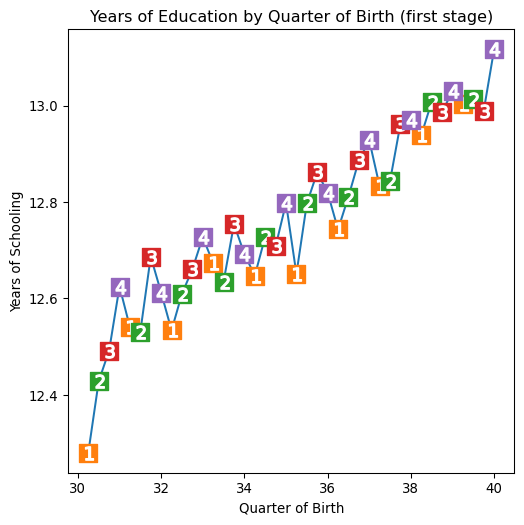

In [7]:
import matplotlib.pyplot as plt
group_data = (df
    .groupby(["year_of_birth", "quarter_of_birth"])
    [["log_wage", "years_of_schooling"]]
    .mean()
    .reset_index()
    .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

plt.figure(figsize=(6,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Quarter of Birth")
plt.ylabel("Years of Schooling");

## Example: Returns to Education

-   Angrist and Krueger (1991) argue that the first assumption is
    reasonable because
    -   The quarter of birth is randomly assigned
    -   The quarter of birth affects education through compulsory
        schooling law
-   The compulsory schooling law is a law that requires students to stay
    in school until a certain age.
    -   In the US, this age is 16.
    -   In Canada, this age is 18.
-   The law is enforced by the government, so it is not affected by the
    ability of the student.

## Example: Returns to Education

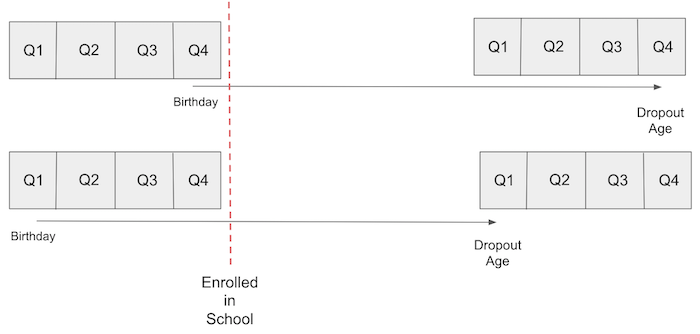

## Example: Returns to Education

-   Unfortunately, there is no way to test the second assumption from
    the data.
    -   We have to assume that it is true.
    -   In this case, it is hard to come up with another plausible
        explanation for why quarter of birth would affect earnings.
-   In the paper, they also add that there is no correlation of QOB with
    college graduation rates, indicating that compulsory schooling laws
    are really driving the effect, not ability.

## Example: Returns to Education

-   First, we run the first stage. To aid interpretation, we’ll use just
    `q4` as our instrument.

In [8]:
# Convert the quarter of birth to dummy variables
factor_data = df.assign(**{f"q{int(q)}": (df["quarter_of_birth"] == q).astype(int)
                             for q in df["quarter_of_birth"].unique()})

# Run the first stage regression
import statsmodels.formula.api as smf

first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272790978
q4 p-value:,  5.464829416479072e-15

## Example: Returns to Education

-   Next, we start looking at the second stage. Do we think this will
    really work?

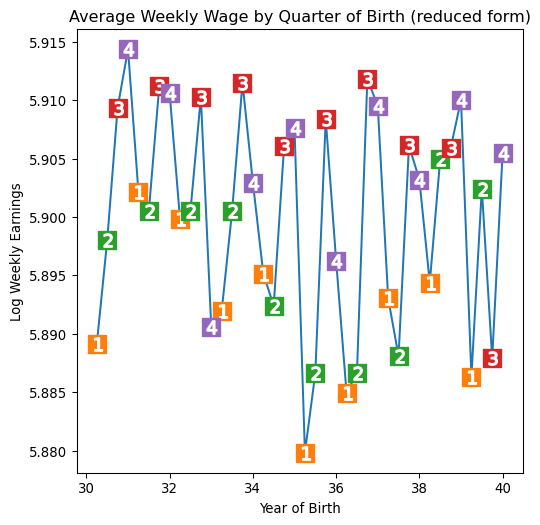

In [9]:
# Plot the reduced form
plt.figure(figsize=(6,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

## Example: Returns to Education

-   The reduced form looks pretty good, but we can’t be sure until we
    run the second stage.

In [10]:
# Run the reduced form
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260163176
q4 p-value:,  0.0014949127183224312

## Example: Returns to Education

-   The second stage looks good, so we can estimate the effect of
    education on earnings.

-   We can do this “by hand” using the formula for $\kappa$.

In [11]:
ate_iv = reduced_form.params["q4"] / first_stage.params["q4"]
print("ATE (IV):", ate_iv)

ATE (IV): 0.08530286492104555

-   This means that we expect earnings to increase by $8\%$ for every
    additional year of school.

## Example: Returns to Education

-   Of course, we wouldn’t usually. We can use the `IV2SLS` function
    from `linearmodels`, which will also give us confidence intervals
    -   There is also a `IVGMM` function available in `statsmodels`.

In [12]:
from linearmodels.iv import IV2SLS

formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv = IV2SLS.from_formula(formula, data=factor_data).fit()
print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_wage   R-squared:                      0.1217
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1215
No. Observations:              329509   F-statistic:                 1.028e+04
Date:                Wed, Nov 01 2023   P-value (F-stat)                0.0000
Time:                        01:21:36   Distribution:                 chi2(60)
Cov. Estimator:                robust                                         
                                                                              
                                     Parameter Estimates                                     
                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------
Intercept                     4.7468     0.2904     16.348     0.0000      4.1777     

# Weak vs Strong Instruments

## Weak vs Strong Instruments

-   Standard errors for instrumental variables are larger than for OLS.

-   The difference comes from the fact that our prediction of $T$ from
    just $R$ is imperfect.

-   The more *correlated* $R$ is with $T$, the better our prediction
    will be.

    -   If $\cov(R,T)$ is large, we call $R$ a **strong instrument**.
    -   If $\cov(R,T)$ is small, we call $R$ a **weak instrument**.

# Monte-Carlo Tests of 2SLS

## Weak vs Strong Instruments

-   To explore the 2SLS estimator, we could use Monte-Carlo simulation.

-   We’ll simulate data from the following model:

$$
\begin{aligned}
& X \sim N\left(0,2^2\right) \\
& U \sim N\left(0,2^2\right) \\
& T \sim N\left(1+0.5 U, 5^2\right) \\
& Y \sim N\left(2+X-0.5 U+2 T, 5^2\right) \\
& Z \sim N\left(T, \sigma^2\right) \text { for } \sigma^2 \text { in } 0.1 \text { to } 100
\end{aligned}
$$

``` python
g = gr.Digraph()
g.edge('U', 'T')
g.edge('X', 'Y')
g.edge('U', 'Y')
g.edge('T', 'Y')
g.edge('T', 'Z')
g
```



## Weak vs Strong Instruments

In [14]:
import numpy as np
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

5 rows × 53 columns

## Weak vs Strong Instruments

-   Now we can run the 2SLS estimator for each value of $\sigma$, as the
    covariance between the instrument and treatment changes.
    -   We can see that the standard error of the 2SLS estimator
        increases as the covariance decreases.

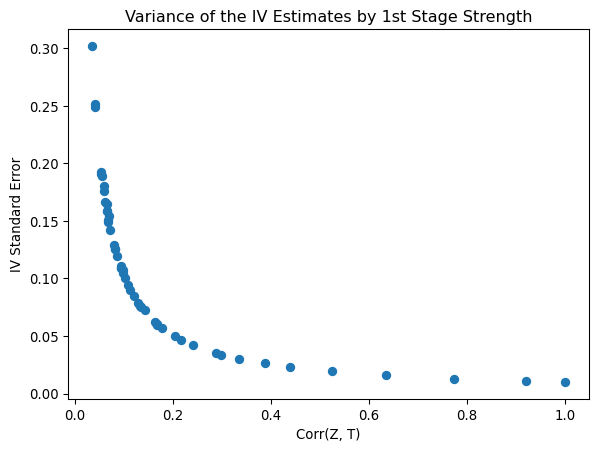

In [15]:
corr = (sim_data.corr()["T"]
    [lambda d: d.index.str.startswith("Z")])

se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

## Bias of OLS

-   Now, let’s look at the point estimates themselves

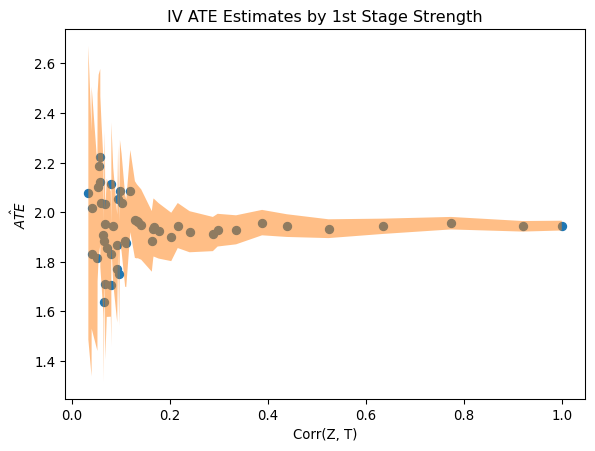

In [16]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
    plot_data["ate"]+1.96*plot_data["se"],
    plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

## Bias of 2SLS

-   We can see that the estimates from 2SLS are still biased.

-   This is because the instrument is not able to “mimic” the randomized
    experiment as well, there will always be some variation in $T$ that
    is not explained by $Z$.

-   2SLS is biased in the same direction as OLS would be.

    -   But it’s consistent!
    -   So we can get rid of the bias by increasing the sample size.

## Credits

This lecture draws heavily from [Causal Inference for the Brave and
True: Chapter 08 - Instrumental
Variables](https://matheusfacure.github.io/python-causality-handbook/08-Instrumental-Variables.html)
by Matheus Facure.

As well as [The Effect: Chapter 19 - Instrumental
Variables](https://www.theeffectbook.net/ch-InstrumentalVariables.html)
by Nick Huntington-Klein.